In [4]:
import ccxt,schedule,warnings,time,ast
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from dateutil.tz import tzlocal
from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
#Supertrend Formula
def tr(data):
    data['previous_close'] = data['close'].shift(1)
    data['high-low'] = abs(data['high'] - data['low'])
    data['high-pc'] = abs(data['high'] - data['previous_close'])
    data['low-pc'] = abs(data['low'] - data['previous_close'])
    tr = data[['high-low', 'high-pc', 'low-pc']].max(axis=1)
    return tr
def atr(data, period):
    data['tr'] = tr(data)
    atr = data['tr'].rolling(period).mean()
    return atr
def supertrend(df, period=7, atr_multiplier=3):
    hl2 = (df['high'] + df['low']) / 2
    df['atr'] = atr(df, period)
    df['upperband'] = hl2 + (atr_multiplier * df['atr'])
    df['lowerband'] = hl2 - (atr_multiplier * df['atr'])
    df['in_uptrend'] = True
    for current in range(1, len(df.index)):
        previous = current - 1
        if df['close'][current] > df['upperband'][previous]:
            df['in_uptrend'][current] = True
        elif df['close'][current] < df['lowerband'][previous]:
            df['in_uptrend'][current] = False
        else:
            df['in_uptrend'][current] = df['in_uptrend'][previous]
            if df['in_uptrend'][current] and df['lowerband'][current] < df['lowerband'][previous]:
                df['lowerband'][current] = df['lowerband'][previous]
            if not df['in_uptrend'][current] and df['upperband'][current] > df['upperband'][previous]:
                df['upperband'][current] = df['upperband'][previous]
    return df

# Data

## Binance Data

In [7]:
ccxt.binanceus({ 'options':{ 'adjustForTimeDifference':True}})
exchange = ccxt.binanceus({#don
"apiKey": "LTBiFxZdR4AP7jFvSsFq4kfHfhNvCeaIXANKDkmvulgwoj9V8uJsqBa3SBcuTVU2",
"secret": "lWSRlGOsXvXBrgCarYeoWLepR2uxOGNHRJgRO58eM5e6lRifyrQtYVrrbA7S50wf",
'enableRateLimit': True})

In [17]:
bars = exchange.fetch_ohlcv('ETH/USD', timeframe="1h", limit=10000)
df = pd.DataFrame(bars[:-1], columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize(None)
supertrend_data_eth = supertrend(df)
supertrend_data_eth

,timestamp,open,high,low,close,volume,previous_close,high-low,high-pc,low-pc,tr,atr,upperband,lowerband,in_uptrend
0,2021-08-07 06:00:00,2970.40,2975.23,2944.07,2962.95,774.79642,NaN,31.16,NaN,NaN,31.16,NaN,NaN,NaN,True
1,2021-08-07 07:00:00,2960.34,2976.22,2948.63,2957.91,454.47965,2962.95,27.59,13.27,14.32,27.59,NaN,NaN,NaN,True
2,2021-08-07 08:00:00,2958.05,2980.46,2944.53,2979.53,758.97239,2957.91,35.93,22.55,13.38,35.93,NaN,NaN,NaN,True
3,2021-08-07 09:00:00,2980.12,3047.21,2970.27,3044.35,2343.46563,2979.53,76.94,67.68,9.26,76.94,NaN,NaN,NaN,True
4,2021-08-07 10:00:00,3043.63,3091.76,3037.80,3071.48,2148.60124,3044.35,53.96,47.41,6.55,53.96,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,2021-09-17 16:00:00,3451.13,3470.53,3425.17,3457.80,1196.71602,3450.73,45.36,19.80,25.56,45.36,53.354286,3591.147143,3287.787143,False
995,2021-09-17 17:00:00,3460.61,3466.36,3411.16,3412.01,925.62841,3457.80,55.20,8.56,46.64,55.20,46.070000,3576.970000,3300.550000,False
996,2021-09-17 18:00:00,3411.34,3413.29,3360.74,3398.65,2074.90387,3412.01,52.55,1.28,51.27,52.55,45.867143,3524.616429,3249.413571,False
997,2021-09-17 19:00:00,3398.40,3426.94,3381.00,3425.87,888.27592,3398.65,45.94,28.29,17.65,45.94,44.355714,3524.616429,3270.902857,False


## Backtest data

In [76]:
# First upload dataframe as df
#Read in historical data.
df  = pq.read_table('DOGE-USDT.parquet').to_pandas().reset_index(drop=False)
df = df.set_index('open_time')['close'].resample('1h').ohlc().reset_index(drop=False)
#df.rename(columns={'open_time':'Date','open': 'Open', 'high': 'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)
df

,open_time,open,high,low,close
0,2019-07-05 12:00:00,0.004200,0.004475,0.003781,0.003925
1,2019-07-05 13:00:00,0.003926,0.003926,0.003765,0.003835
2,2019-07-05 14:00:00,0.003829,0.003919,0.003820,0.003841
3,2019-07-05 15:00:00,0.003840,0.003869,0.003710,0.003738
4,2019-07-05 16:00:00,0.003727,0.003727,0.003643,0.003666
...,...,...,...,...,...
13039,2020-12-29 19:00:00,0.004434,0.004469,0.004398,0.004436
13040,2020-12-29 20:00:00,0.004441,0.004444,0.004418,0.004426
13041,2020-12-29 21:00:00,0.004426,0.004469,0.004419,0.004445
13042,2020-12-29 22:00:00,0.004442,0.004480,0.004433,0.004463


In [147]:
!pip install pillow

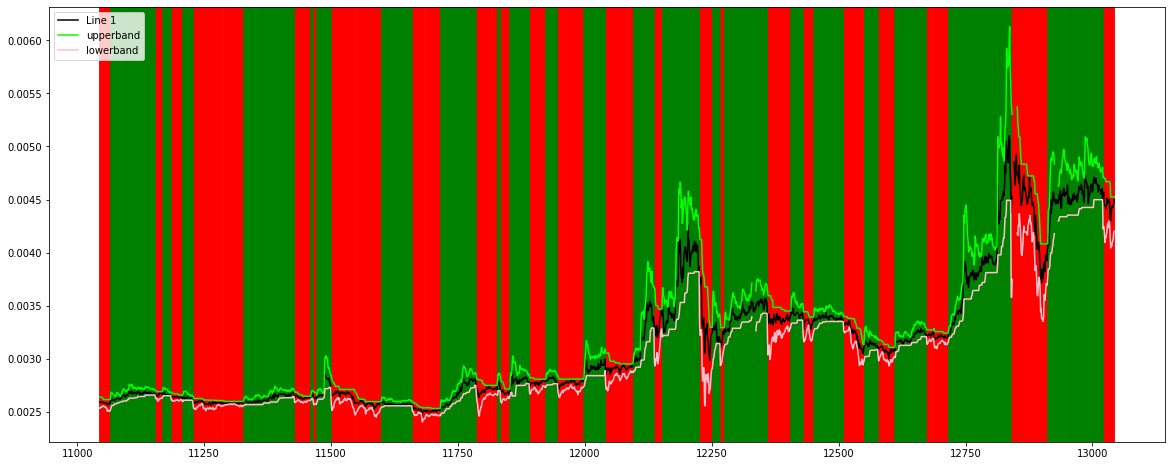

In [152]:

fig, ax = plt.subplots(figsize=(20, 8))
#SMA CONDITIONS
#If purple above blue, we sell. Red.
xcoords_sell = supertrend_data_backtest_doge.tail(2000)[supertrend_data_backtest_doge.in_uptrend == False].index

#If purple below blue, we sell. Green.
xcoords_buy = supertrend_data_backtest_doge.tail(2000)[supertrend_data_backtest_doge.in_uptrend == True].index

#EXECUTIONS
for xc in xcoords_sell:
    plt.axvline(x=xc,c='r')

for xc in xcoords_buy:
    plt.axvline(x=xc,c='g')


ax.plot(supertrend_data_backtest_doge.tail(2000).close, color = 'black', label = 'Line 1')
ax.plot(supertrend_data_backtest_doge.tail(2000).upperband, color = 'lime', label = 'upperband')
ax.plot(supertrend_data_backtest_doge.tail(2000).lowerband, color = 'pink', label = 'lowerband')
ax.legend(loc = 'upper left')
plt.savefig('doge_supertrend.jpg')
plt.show()

In [151]:
supertrend_data_backtest_doge.tail(2000).open_time

11044   2020-10-07 16:00:00
11045   2020-10-07 17:00:00
11046   2020-10-07 18:00:00
11047   2020-10-07 19:00:00
11048   2020-10-07 20:00:00
11049   2020-10-07 21:00:00
11050   2020-10-07 22:00:00
11051   2020-10-07 23:00:00
11052   2020-10-08 00:00:00
11053   2020-10-08 01:00:00
11054   2020-10-08 02:00:00
11055   2020-10-08 03:00:00
                ...        
13032   2020-12-29 12:00:00
13033   2020-12-29 13:00:00
13034   2020-12-29 14:00:00
13035   2020-12-29 15:00:00
13036   2020-12-29 16:00:00
13037   2020-12-29 17:00:00
13038   2020-12-29 18:00:00
13039   2020-12-29 19:00:00
13040   2020-12-29 20:00:00
13041   2020-12-29 21:00:00
13042   2020-12-29 22:00:00
13043   2020-12-29 23:00:00
Name: open_time, Length: 2000, dtype: datetime64[ns]